## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np


import plotly.offline as py
py.init_notebook_mode(connected=False)
import cufflinks as cf
cf.set_config_file(offline=True)

from sklearn.metrics import accuracy_score
import xgboost
import pickle
import swifter

### Importing data from MongoDb and saving it as pickle file 

In [2]:
# from pymongo import MongoClient

# client = MongoClient()

# snapshot = client.articles.snapshot

# data = snapshot.find({
#     '_source.published_at': {
#         '$gte': "2020-04-01 00:00:00",
#         '$lt': "2020-05-01 00:00:00" 
#     }
# })

# articles_04_2020 = pd.json_normalize(data)

In [3]:
# articles_08_2019.to_pickle("articles_08_2019.pkl")

### Reading the files

In [4]:
articles_07_2019 = pd.read_pickle('articles_07_2019.pkl')
articles_08_2019 = pd.read_pickle('articles_08_2019.pkl')
articles_09_2019 = pd.read_pickle('articles_09_2019.pkl')
articles_10_2019 = pd.read_pickle('articles_10_2019.pkl')
articles_11_2019 = pd.read_pickle('articles_11_2019.pkl')
articles_12_2019 = pd.read_pickle('articles_12_2019.pkl')

## Exploratory Data Analysis

In [5]:
# Merging all the files together

all_articles = pd.concat([articles_07_2019, articles_08_2019, articles_09_2019, articles_10_2019, articles_11_2019, articles_12_2019])

In [6]:
# Removing unwanted columns

all_articles = all_articles.drop(['_id', '_index', '_type', '_score', '_source.top_image_url', '_source.updated_at', '_source.type', '_source.published_at', '_source.lang', '_source.isTestSample'], axis = 1)

In [110]:
all_articles.shape

(2461607, 6)

In [8]:
articles_not_null = all_articles[all_articles['_source.section'].isna()==False]

In [9]:
articles_not_null.shape

(1519909, 6)

In [131]:
print('Percentage of null articles : {}%'.format(format(((all_articles.shape[0] - articles_not_null.shape[0])/all_articles.shape[0] * 100), '.2f')))

Percentage of null articles : 38.26%


#### Out of all the articles crawled, around 40% of the articles have no category assigned. Out of the rest 60% articles, most of the categories are not consistent and are categorized as featuers, concerts, colorado news, etc. So, wherever a category contained the string given below, the articles have been categorized accordingly for consistency. Also, these categories have been chosen as they were most frequent and they were relevant/important.

In [10]:
articles_not_null["_source.section"] = articles_not_null["_source.section"].astype(str)
articles_not_null["_source.section"] = articles_not_null["_source.section"].str.lower()

In [11]:
articles_not_null['category'] = np.where(articles_not_null["_source.section"].str.contains('auto'), 'auto',
                                      np.where(articles_not_null["_source.section"].str.contains('tech'), 'tech',
                                              np.where(articles_not_null["_source.section"].str.contains('politics'), 'politics',
                                                      np.where(articles_not_null["_source.section"].str.contains('business'), 'business',
                                                              np.where(articles_not_null["_source.section"].str.contains('sports'), 'sports',
                                                                      np.where(articles_not_null["_source.section"].str.contains('lifestyle'), 'lifestyle',
                                                                                np.where(articles_not_null["_source.section"].str.contains('entertainment'), 'entertainment',
                                                                                        np.where(articles_not_null["_source.section"].str.contains('transport|logistic'), 'logistics',
                                                                                                 np.where(articles_not_null["_source.section"].str.contains('economy'), 'economy',
                                                                                                          np.where(articles_not_null["_source.section"].str.contains('stock|market'), 'markets',
                                                                                                                   np.where(articles_not_null["_source.section"].str.contains('education'), 'education',
                                                                                                                            np.where(articles_not_null["_source.section"].str.contains('health'), 'health',
                                                                                                                                     np.where(articles_not_null["_source.section"].str.contains('startup|start-up'), 'startup',
                                                                                                                                             np.where(articles_not_null["_source.section"].str.contains('travel|leisure'), 'travel',
                                                                                                                                                      np.where(articles_not_null["_source.section"].str.contains('gaming'), 'gaming',
                                                                                                                                                              np.where(articles_not_null["_source.section"].str.contains('murder|crime'), 'crime',
                                                                                                                                                                      np.where(articles_not_null["_source.section"].str.contains('bank'), 'banking',
                                                                                                                                                                              np.where(articles_not_null["_source.section"].str.contains('food'), 'food', 
                                                                                                                                                                                      np.where(articles_not_null["_source.section"].str.contains('finance'), 'finance', 'others')))))))))))))))))))

In [12]:
articles_not_null

,_source.domain,_source.section,_source.body,_source.headline,_source.url,_source.authors,category
0,deccanchronicle.com,lifestyle,Washington: We are surrounded by so many colou...,How does human brain encode visual information,deccanchronicle.com/lifestyle/health-and-wellb...,"[{'influencer_id': None, 'name': 'Ani', 'id': 1}]",lifestyle
1,deccanchronicle.com,lifestyle,Tokyo: Japanese fishermen will set sail on Mon...,Japan&amp;rsquo;s commercial whaling likely to...,deccanchronicle.com/lifestyle/environment/0107...,"[{'influencer_id': None, 'name': 'Afp', 'id': 9}]",lifestyle
2,deccanchronicle.com,nation,Mangaluru: In a shocking incident which brough...,Air India plane skids off Mangaluru runway,deccanchronicle.com/nation/current-affairs/010...,"[{'influencer_id': None, 'name': 'Gururaj A Pa...",others
3,deccanchronicle.com,technology,For a long while Apple had something to show o...,Android to finally get fantastic Apple AirDrop...,deccanchronicle.com/technology/mobiles-and-tab...,"[{'influencer_id': None, 'name': 'Deccan Chron...",tech
4,deccanchronicle.com,technology,Central banks grappling with fast-changing fin...,World&amp;#039;s central banks tackle technolo...,deccanchronicle.com/technology/in-other-news/0...,"[{'influencer_id': None, 'name': 'Reuters', 'i...",tech
...,...,...,...,...,...,...,...
464234,denverpost.com,colorado news,"Citing a recent change in “circumstances,” the...",Aurora deputy chief who responded to drunken o...,denverpost.com/2019/12/24/aurora-deputy-chief-...,"[{'id': 280509, 'name': 'Alex Burness', 'influ...",others
464235,clickondetroit.com,features,DETROIT – The holiday season is alive in Michi...,7 places to see amazing holiday light displays...,clickondetroit.com/features/2019/12/06/7-place...,"[{'id': 280249, 'name': 'Ken Haddad', 'influen...",others
464236,clickondetroit.com,features,"DETROIT – Martin Scorsese’s new film, “The Iri...",Fact vs. Myth: What ‘The Irishman’ got wrong a...,clickondetroit.com/features/2019/12/02/fact-vs...,"[{'id': 307737, 'name': 'Zak Rosen', 'influenc...",others
464237,pe.com,music + concerts,"Chicago-area rapper Juice WRLD, whose real nam...",Rapper Juice WRLD dies after medical emergency...,pe.com/2019/12/08/rapper-juice-wrld-dies-after...,"[{'id': 286911, 'name': 'Associated Press', 'i...",others


#### Some of the categories which we needed were not enough for training a machine learning model so these categories have been further extracted from other categories using keywords.

In [30]:
articles_not_null['category'] = np.where((articles_not_null['_source.headline'].str.contains('logistics|agarwal packers|blue dart|fedex|safexpress|allcargo|dhl express|gati ltd|trucking|transport', case  = False)) & (articles_not_null['category'].str.contains('business|others', case = False)), 'logistics',
                                          np.where((articles_not_null['_source.headline'].str.contains('bank', case  = False)) & (articles_not_null['category'].str.contains('business|others', case = False)), 'banking',
                                                  np.where((articles_not_null['_source.headline'].str.contains('startup|start-up|fintech|insurtech|fin-tech|insur-tech|series a|series b|series c|series d|seed funding|raises series', case  = False)) & (articles_not_null['category'].str.contains('business|others', case = False)), 'startup',
                                                           np.where((articles_not_null['_source.headline'].str.contains('inflation|repo rate|economy|gdp|gst', case  = False)) & (articles_not_null['category'].str.contains('business|others', case = False)), 'economy', 
                                                                    np.where((articles_not_null['_source.url'].str.contains('travel|tourism', case  = False)) & (articles_not_null['category'].str.contains('lifestyle', case  = False)), 'travel', articles_not_null['category'])))))

In [31]:
articles_not_null.groupby('category').size()

category
auto                5987
banking            16898
business           47604
crime              10458
economy            15575
education          11384
entertainment      60068
finance             3562
food                4260
gaming              3874
health              8741
lifestyle          14084
logistics           2953
markets            24495
others           1163046
politics           28446
sports             55834
startup             8075
tech               30799
travel              3766
dtype: int64

In [32]:
articles_not_others = articles_not_null[articles_not_null['category'] != 'others']

In [33]:
articles_not_others.shape

(356863, 7)

In [34]:
articles_not_others

,_source.domain,_source.section,_source.body,_source.headline,_source.url,_source.authors,category
0,deccanchronicle.com,lifestyle,Washington: We are surrounded by so many colou...,How does human brain encode visual information,deccanchronicle.com/lifestyle/health-and-wellb...,"[{'influencer_id': None, 'name': 'Ani', 'id': 1}]",lifestyle
1,deccanchronicle.com,lifestyle,Tokyo: Japanese fishermen will set sail on Mon...,Japan&amp;rsquo;s commercial whaling likely to...,deccanchronicle.com/lifestyle/environment/0107...,"[{'influencer_id': None, 'name': 'Afp', 'id': 9}]",lifestyle
3,deccanchronicle.com,technology,For a long while Apple had something to show o...,Android to finally get fantastic Apple AirDrop...,deccanchronicle.com/technology/mobiles-and-tab...,"[{'influencer_id': None, 'name': 'Deccan Chron...",tech
4,deccanchronicle.com,technology,Central banks grappling with fast-changing fin...,World&amp;#039;s central banks tackle technolo...,deccanchronicle.com/technology/in-other-news/0...,"[{'influencer_id': None, 'name': 'Reuters', 'i...",tech
6,deccanchronicle.com,lifestyle,Washington: We all love to preserve the well-d...,Using liquor bottles for decoration can be har...,deccanchronicle.com/lifestyle/health-and-wellb...,"[{'influencer_id': None, 'name': 'Ani', 'id': 1}]",lifestyle
...,...,...,...,...,...,...,...
464210,marketwatch.com,economy & politics,\nBEIJING — China’s government says it will po...,China says it will put off tariff hike on U.S....,marketwatch.com/story/china-says-it-will-put-o...,"[{'id': 216979, 'name': 'Associated Press', 'i...",politics
464216,thehill.com,congress blog - politics,\nTrump administration's plans for SNAP are a ...,Trump administration's plans for SNAP are a sh...,thehill.com/blogs/congress-blog/politics/47432...,"[{'id': 216954, 'name': 'Opinion Contributor',...",politics
464217,thehill.com,congress blog - politics,\nWelfare is killing the American dream\n\n\n ...,Welfare is killing the American dream | TheHill,thehill.com/blogs/congress-blog/politics/47419...,"[{'id': 226028, 'name': 'Cliff Maloney', 'infl...",politics
464222,moeckern24.de,technologie,Die Marktforschungsstudie von Innovate Insight...,Globaler und regionaler Luftdatenboom markt 20...,moeckern24.de/2019/12/13/globaler-und-regional...,"[{'id': 325737, 'name': 'Innovate', 'influence...",tech


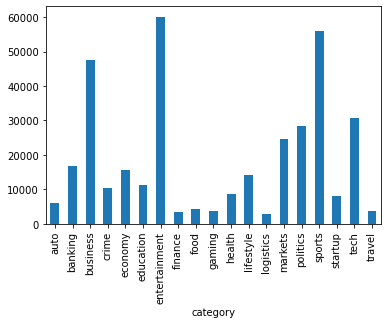

In [35]:
articles_not_others.groupby('category').size().reset_index().plot(x = 'category', y = 0, kind = 'bar', legend = False)

In [36]:
articles_not_others_1 = articles_not_others.copy()

#### Categories such as business, entertainment and sports have been undersampled so that the categories are more balanced.

In [37]:
for i in ['business', 'entertainment', 'sports']:
    articles_not_others_1 = articles_not_others_1.drop(articles_not_others_1[articles_not_others_1['category'] == i].sample(frac=.5, random_state = 0).index)

In [51]:
articles_not_others_1.shape

(235555, 8)

In [50]:
articles_not_others_1.groupby('category').size()

category
auto              5069
banking          14330
business         20438
crime             9192
economy          13286
education         9714
entertainment    25533
finance           3057
food              3703
gaming            3272
health            7483
lifestyle        11989
logistics         2501
markets          21001
politics         24541
sports           23772
startup           6872
tech             26561
travel            3241
dtype: int64

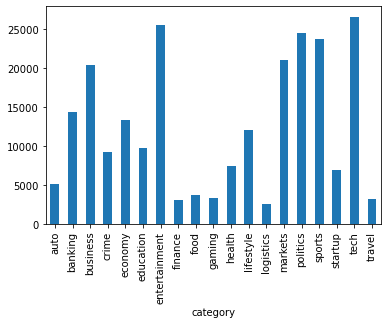

In [38]:
articles_not_others_1.groupby('category').size().reset_index().plot(x = 'category', y = 0, kind = 'bar', legend = False)

### Data Preprocessing

In [39]:
articles_not_others_1['headline_body'] = articles_not_others_1['_source.headline'] + " " + articles_not_others_1['_source.body']
articles_not_others_1['headline_body'] = articles_not_others_1['headline_body'].str.lower()
articles_not_others_1['headline_body'] = articles_not_others_1['headline_body'].str.replace(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', ' ')
articles_not_others_1['headline_body'] = articles_not_others_1['headline_body'].str.replace('\r|\n', ' ')
articles_not_others_1['headline_body'] = articles_not_others_1['headline_body'].str.replace('http\S+|www.\S+', ' ', case=False)
articles_not_others_1['headline_body'] = articles_not_others_1['headline_body'].str.replace("[^a-z-']+", " ")
articles_not_others_1['headline_body'] = articles_not_others_1['headline_body'].str.replace("\s+", " ")
articles_not_others_1['headline_body']

0         how does human brain encode visual information...
1         japan rsquo s commercial whaling likely to spa...
3         android to finally get fantastic apple airdrop...
4         world s central banks tackle technology with i...
6         using liquor bottles for decoration can be har...
                                ...                        
464210    china says it will put off tariff hike on u s ...
464216    trump administration's plans for snap are a sh...
464217    welfare is killing the american dream thehill ...
464222    globaler und regionaler luftdatenboom markt - ...
464239    fox news guest urges senate to refuse to hold ...
Name: headline_body, Length: 235555, dtype: object

In [40]:
articles_not_others['_source.body'][0]

'Washington: We are surrounded by so many colours and shapes that we can distinguish visually but have you ever wondered how our brain interprets them? A recent study has shown that there are neurons that respond selectively to particular combinations of colour and shape.\r\n\r\nThe study was published in the journal &#39;Science&#39;. "New genetic sensors and imaging technologies have allowed us to more thoroughly test the link between visual circuits that process colour and shape. These findings provide valuable insight about how visual circuits are connected and organised in the brain," said Edward Callaway, senior author of the study.\r\n\r\nSimilar to a digital camera sensor, light-sensitive cells in the eye (photoreceptors) detect wavelengths of light within specific ranges and at particular locations. This information then travels through the optic nerve to neurons in the visual cortex that interprets the information and begins to decipher the contents of the picture.\r\n\r\n"Th

In [41]:
articles_not_others_1['headline_body'][0]

'how does human brain encode visual information washington we are surrounded by so many colours and shapes that we can distinguish visually but have you ever wondered how our brain interprets them a recent study has shown that there are neurons that respond selectively to particular combinations of colour and shape the study was published in the journal science new genetic sensors and imaging technologies have allowed us to more thoroughly test the link between visual circuits that process colour and shape these findings provide valuable insight about how visual circuits are connected and organised in the brain said edward callaway senior author of the study similar to a digital camera sensor light-sensitive cells in the eye photoreceptors detect wavelengths of light within specific ranges and at particular locations this information then travels through the optic nerve to neurons in the visual cortex that interprets the information and begins to decipher the contents of the picture th

In [42]:
articles_not_others['_source.body'][1]

'Tokyo: Japanese fishermen will set sail on Monday to hunt whales commercially for the first time in more than three decades, after Tokyo&#39;s controversial decision to withdraw from the International Whaling Commission.\r\n\r\nThe hunts are likely to spark criticism from environmentalists and anti-whaling countries, but are cause for celebration among whaling communities in Japan, which says the practice is a long-standing tradition.\r\n\r\nThe issue has been a diplomatic headache for Japan for years, with Tokyo using a loophole in the IWC rules to carry out hunts in protected Antarctic waters for &quot;scientific&quot; research purposes.\r\n\r\nThose hunts were fiercely criticised, and Japan decided last year to withdraw from the IWC after repeatedly failing to convince the body to allow it to resume full-scale commercial whaling.\r\n\r\nWhaling ships will set sail on commercial hunts from several parts of Japan on Monday, including the town of Kushiro in northern Japan&#39;s Hokkai

In [43]:
articles_not_others_1['headline_body'][1]

'japan rsquo s commercial whaling likely to spark firestorm of criticism tokyo japanese fishermen will set sail on monday to hunt whales commercially for the first time in more than three decades after tokyo s controversial decision to withdraw from the international whaling commission the hunts are likely to spark criticism from environmentalists and anti-whaling countries but are cause for celebration among whaling communities in japan which says the practice is a long-standing tradition the issue has been a diplomatic headache for japan for years with tokyo using a loophole in the iwc rules to carry out hunts in protected antarctic waters for scientific research purposes those hunts were fiercely criticised and japan decided last year to withdraw from the iwc after repeatedly failing to convince the body to allow it to resume full-scale commercial whaling whaling ships will set sail on commercial hunts from several parts of japan on monday including the town of kushiro in northern j

In [44]:
articles_not_others['_source.body'][464217]

'\nWelfare is killing the American dream\n\n\n    By Cliff Maloney, Opinion Contributor —  12/12/19 09:30 AM EST\n\n\n    The views expressed by contributors are their own and not the view of The Hill  \n\n\n'

In [45]:
articles_not_others_1['headline_body'][464217]

'welfare is killing the american dream thehill welfare is killing the american dream by cliff maloney opinion contributor am est the views expressed by contributors are their own and not the view of the hill '

In [46]:
articles_not_others['_source.body'][464239]

'\nDuring Wednesday\'s episode of\xa0The Ingraham Angle on Fox News, former Whitewater independent counsel Robert Ray said that President Donald Trump\'s impeachment case "doesn\'t deserve" a trial in the senate and that Republican senators should unanimously "show some courage" and deny an impeachment trial "for the benefit of the country."\n\n"I do think that the articles will, one way or another, make their way to the senate. Never underestimate the good sense of the American people...\xa0 this is now become ridiculous, and as you have said for many months, this has got to stop," Ray concluded.\nRay has continuously called for Republican senators to dismiss the articles of impeachment against President Donald Trump. His appearance on the Ingraham Angle is the second time he\'d made a similar plea on a Fox channel.\n"For all the talk by House Republicans about the fact that the president should not be above the law, it would have been nice if one of the impeachment articles charged a

In [47]:
articles_not_others_1['headline_body'][464239]

"fox news guest urges senate to refuse to hold impeachment trial during wednesday's episode of the ingraham angle on fox news former whitewater independent counsel robert ray said that president donald trump's impeachment case doesn't deserve a trial in the senate and that republican senators should unanimously show some courage and deny an impeachment trial for the benefit of the country i do think that the articles will one way or another make their way to the senate never underestimate the good sense of the american people this is now become ridiculous and as you have said for many months this has got to stop ray concluded ray has continuously called for republican senators to dismiss the articles of impeachment against president donald trump his appearance on the ingraham angle is the second time he'd made a similar plea on a fox channel for all the talk by house republicans about the fact that the president should not be above the law it would have been nice if one of the impeachm

In [48]:
articles_not_others['_source.body'][4]

'Central banks grappling with fast-changing financial technology and companies like Facebook moving into finance will aim to work together more closely through an innovation hub approved on Sunday by the Bank for International Settlements.\r\n\r\nThe BIS said the intention of the hub, which will be based in Basel, Hong Kong and Singapore, is to improve the functioning of the global financial system and it will identify and develop insights into trends in technology affecting central banking.\r\n\r\nFacebook&rsquo;s plan to expand into payments and launch its own Libra cryptocurrency were not mentioned in the BIS statement, but the social media giant&rsquo;s move has helped crystallize opinion among central bankers on the urgency of coordinating regulatory responses to financial technology trends.\r\n\r\n&ldquo;The IT revolution knows no borders and therefore has repercussions in multiple locations simultaneously,&rdquo; BIS Chairman Jens Weidmann said in a statement following the decis

In [49]:
articles_not_others_1['headline_body'][4]

'world s central banks tackle technology with innovation hub central banks grappling with fast-changing financial technology and companies like facebook moving into finance will aim to work together more closely through an innovation hub approved on sunday by the bank for international settlements the bis said the intention of the hub which will be based in basel hong kong and singapore is to improve the functioning of the global financial system and it will identify and develop insights into trends in technology affecting central banking facebook s plan to expand into payments and launch its own libra cryptocurrency were not mentioned in the bis statement but the social media giant s move has helped crystallize opinion among central bankers on the urgency of coordinating regulatory responses to financial technology trends the it revolution knows no borders and therefore has repercussions in multiple locations simultaneously bis chairman jens weidmann said in a statement following the 

In [52]:
articles_not_others_1['headline_body'] = articles_not_others_1['headline_body'].str.split()
articles_not_others_1['word_length'] = articles_not_others_1['headline_body'].str.len()

# Doing this will remove all the rows having hindi words
articles_not_others_1 = articles_not_others_1[articles_not_others_1['word_length'] > 20]

#### The model will be trained on the data given below.

In [55]:
articles_not_others_1.shape

(220064, 9)

In [56]:
articles_not_others_1.groupby('category').size()

category
auto              4555
banking          13548
business         18532
crime             7336
economy          12841
education         9225
entertainment    23092
finance           2843
food              3534
gaming            3267
health            6232
lifestyle        11062
logistics         2472
markets          20723
politics         23291
sports           21987
startup           6862
tech             25725
travel            2937
dtype: int64

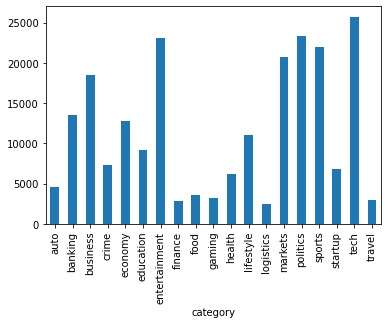

In [54]:
articles_not_others_1.groupby('category').size().reset_index().plot(x = 'category', y = 0, kind = 'bar', legend = False)

In [57]:
def remove_short_words(text):
    words = [w for w in text if len(w) > 2]
    return words

In [58]:
articles_not_others_1['headline_body'] = articles_not_others_1['headline_body'].swifter.apply(lambda x: remove_short_words(x))

C:\Users\HP\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [59]:
new_words = ["div", "style", "nbsp", "font", "http", "bodytext", "class", "href", "rdquo", "ldquo", "an", "rsquo", "news", "0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]

In [60]:
def remove_stopwords(text):
    words = [w for w in text if w not in new_words]
    return words

In [61]:
articles_not_others_1['headline_body'] = articles_not_others_1['headline_body'].swifter.apply(lambda x: remove_stopwords(x))

In [62]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = " ".join([lemmatizer.lemmatize(w) for w in text])
    return lem_text

In [63]:
articles_not_others_1['headline_body']  = articles_not_others_1['headline_body'].swifter.apply(lambda x: word_lemmatizer(x))

In [64]:
articles_not_others_1['category_one_hot'] = np.where(articles_not_others_1["category"] == 'auto', 0,
                                                   np.where(articles_not_others_1["category"] == 'tech', 1,
                                                            np.where(articles_not_others_1["category"] == 'politics', 2,
                                                                     np.where(articles_not_others_1["category"] == 'business', 3,
                                                                              np.where(articles_not_others_1["category"] == 'sports', 4,
                                                                                       np.where(articles_not_others_1["category"] == 'lifestyle', 5,
                                                                                                np.where(articles_not_others_1["category"] == 'entertainment', 6,
                                                                                                         np.where(articles_not_others_1["category"] == 'logistics', 7,
                                                                                                                  np.where(articles_not_others_1["category"] == 'economy', 8,
                                                                                                                           np.where(articles_not_others_1["category"] == 'markets', 9,
                                                                                                                                    np.where(articles_not_others_1["category"] == 'education', 10,
                                                                                                                                             np.where(articles_not_others_1["category"] == 'health', 11,
                                                                                                                                                      np.where(articles_not_others_1["category"] == 'startup', 12,
                                                                                                                                                              np.where(articles_not_others_1["category"] == 'travel', 13,
                                                                                                                                                                      np.where(articles_not_others_1["category"] == 'gaming', 14,
                                                                                                                                                                              np.where(articles_not_others_1["category"] == 'crime', 15,
                                                                                                                                                                                      np.where(articles_not_others_1["category"] == 'banking', 16, 
                                                                                                                                                                                              np.where(articles_not_others_1["category"] == 'food', 17, 
                                                                                                                                                                                                      np.where(articles_not_others_1["category"] == 'finance', 18, 19)))))))))))))))))))

In [65]:
# articles_not_others_1.to_pickle('articles_not_others_2020.pkl')

In [66]:
X = articles_not_others_1['headline_body']
y = articles_not_others_1['category_one_hot']

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [68]:
# Parameter selection
ngram_range = (1,2)
min_df = 0.002
max_df = 0.5

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        max_df=max_df,
                        min_df=min_df)
                        
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test)
labels_test = y_test
print(features_test.shape)

(176051, 11761)
(44013, 11761)


In [70]:
category_section = articles_not_others_1[['category', 'category_one_hot']].drop_duplicates()
category_to_section = dict(category_section.values)

labels = articles_not_others_1.category_one_hot

In [71]:
# Get the most corelated words with respect to each category

from sklearn.feature_selection import chi2
import numpy as np

for section, category in sorted(category_to_section.items()):
    features_chi2 = chi2(features_train, labels_train == category)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(section))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-3:])))
    print("")

# 'auto' category:
  . Most correlated unigrams:
. honda
. rpm
. suzuki
. suv
. hyundai
  . Most correlated bigrams:
. lakh ex
. ex showroom
. maruti suzuki

# 'banking' category:
  . Most correlated unigrams:
. depositor
. loan
. banking
. pmc
. bank
  . Most correlated bigrams:
. punjab maharashtra
. bank india
. pmc bank

# 'business' category:
  . Most correlated unigrams:
. tonne
. boeing
. crore
. airline
. company
  . Most correlated bigrams:
. point cent
. bharti airtel
. air india

# 'crime' category:
  . Most correlated unigrams:
. victim
. sheriff
. suspect
. arrested
. police
  . Most correlated bigrams:
. police station
. county sheriff
. year old

# 'economy' category:
  . Most correlated unigrams:
. tax
. inflation
. gdp
. economy
. gst
  . Most correlated bigrams:
. good service
. gst council
. gdp growth

# 'education' category:
  . Most correlated unigrams:
. recruitment
. student
. examination
. candidate
. exam
  . Most correlated bigrams:
. visit official
. admit c

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


logistic_reg = LogisticRegression()
cv_score_logistic = cross_val_score(logistic_reg, features_train, labels_train, scoring='accuracy', cv=4, n_jobs=-1)
cv_score_logistic.mean()

0.7936790973290282

In [74]:
from sklearn.svm import LinearSVC

model_svc = LinearSVC()
cv_score_svc = cross_val_score(model_svc, features_train, labels_train, scoring='accuracy', cv=4, n_jobs=-1)
cv_score_svc.mean()

0.8001772140944476

In [77]:
from sklearn.model_selection import cross_val_score
import xgboost

xgboost = xgboost.XGBClassifier()
cv_score_xgboost = cross_val_score(xgboost, features_train, labels_train, scoring='accuracy', cv=4, n_jobs=-1)
cv_score_xgboost.mean()

0.8053575320655748

In [79]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
cv_score_randomf = cross_val_score(clf, features_train, labels_train, scoring='accuracy', cv=4, n_jobs=-1)
cv_score_randomf.mean()

0.7683171260608788

In [81]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
cv_score_multinb = cross_val_score(clf, features_train, labels_train, scoring='accuracy', cv=4, n_jobs=-1)
cv_score_multinb.mean()

0.7361048715438749

In [82]:
from sklearn.svm import SVC
clf = SVC()
cv_score_svc = cross_val_score(clf, features_train, labels_train, scoring='accuracy', cv=4, n_jobs=-1)
cv_score_svc.mean()

0.8039147634811299

### The accuracy of models are: 
#### 1.Logistic Regression: 79.4% 
#### 2. LinearSVC: 80% 
#### 3. XGBoost: 80.5% 
#### 4. Random Forest: 76.8% 
#### 5. MultinomialNB: 73.6% 
#### 6. SVC: 80.4% 

In [84]:
import xgboost
xgboost = xgboost.XGBClassifier()
xgboost.fit(features_train, labels_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [85]:
xg_pred = xgboost.predict(features_test)

In [86]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(labels_test, xg_pred)*100
print(format(accuracy, '.2f'))

81.20


In [119]:
xg_pred_train = xgboost.predict(features_train)

In [120]:
from sklearn.metrics import accuracy_score

accuracy_train = accuracy_score(labels_train, xg_pred_train)*100
print(format(accuracy_train, '.2f'))

89.83


#### Accuracy with the test data-set: 81.2%
#### Accuracy with the trained data-set: 89.8%
#### Since the accuracy with the trained data-set is not very high, the model is not overfitted.

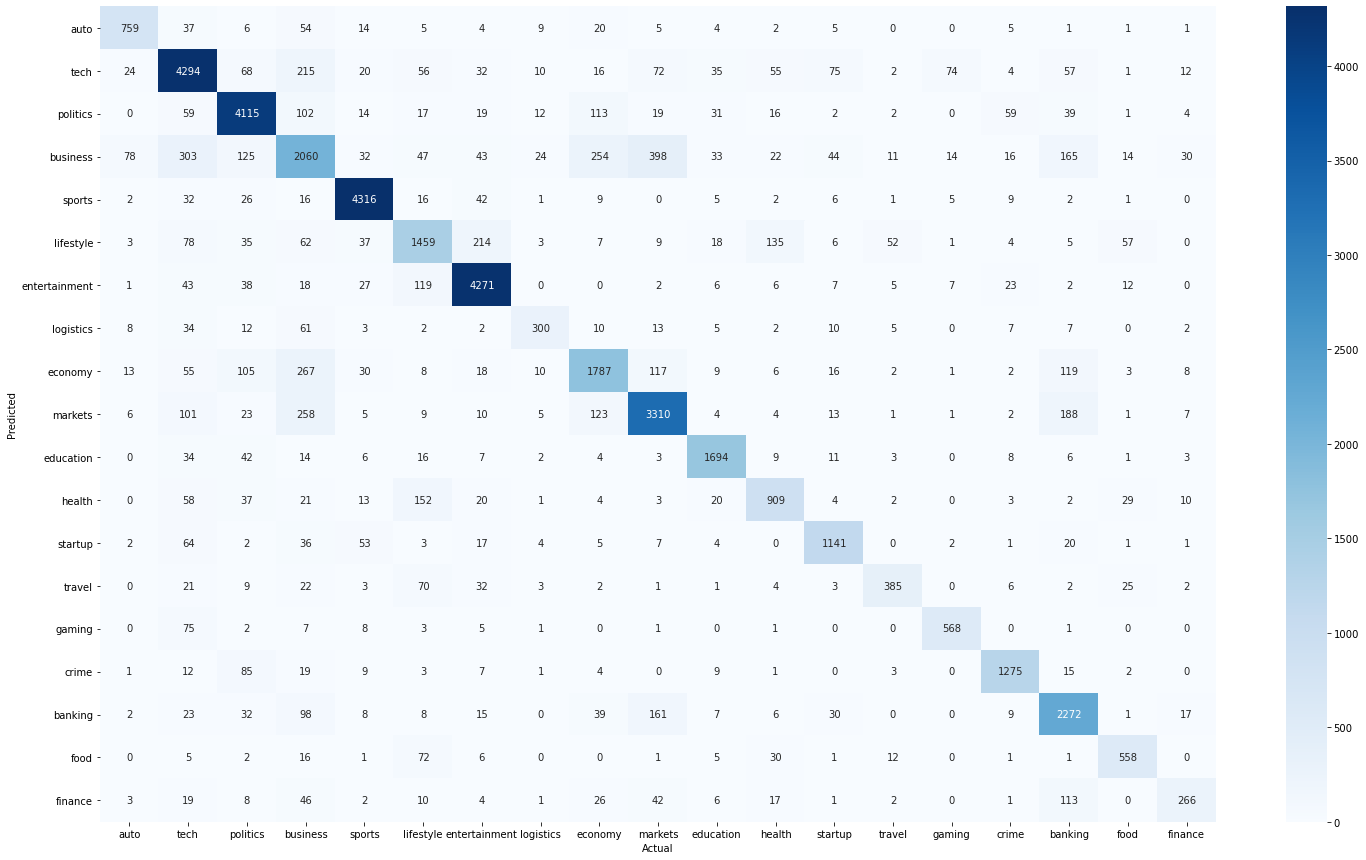

In [87]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.pyplot import savefig
aux_df = articles_not_others_1[['category', 'category_one_hot']].drop_duplicates().sort_values('category_one_hot')
conf_matrix = confusion_matrix(labels_test, xg_pred)
plt.figure(figsize=(25, 15))
sns.heatmap(conf_matrix, 
            annot=True,
            fmt = '',
            xticklabels=aux_df['category'].values, 
            yticklabels=aux_df['category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
# plt.savefig("category_heatmap.png")
plt.show()
plt.close()

In [111]:
# Parameter selection
ngram_range = (1,2)
min_df = 0.002
max_df = 0.5

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        max_df=max_df,
                        min_df=min_df)
                        
features_train = tfidf.fit_transform(X)
labels_train = y
print(features_train.shape)

# features_test = tfidf.transform(X_test)
# labels_test = y_test
# print(features_test.shape)

(220064, 11757)


In [114]:
import xgboost
xgboost = xgboost.XGBClassifier()
xgboost.fit(features_train, labels_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [ ]:
pickle.dump(tfidf, open('tfidf_2020.pkl', 'wb'))
pickle.dump(xgboost, open('xgboost_2020.pkl', 'wb'))

## Final Conclusion: